In [2]:
%matplotlib inline

<!-- omit in toc -->
# questions

* programme python qui prend une image array en entrée ?  
  terminal script.py + argument par ex l'image  
  $ python script.py --file pah_to_image.png  
  argparse librairie (pré installée)  

<!-- omit in toc -->
# Classez des images à l'aide d'algorithmes de Deep Learning
---

<img src="../img/cv.png" width="600px">    

<!-- omit in toc -->
# sommaire

[1. Problématique](#1-problématique)
  - [1.1 Processus envisagé](#11-processus-envisagé)
  - [1.2 Flowchart](#12-flowchart)

# 1. Problématique

Obtenir un algorithme capable de **classer les images en fonction de la race du chien** présent sur l'image.  

C'est un exercice de **classification supervisée** dans le domaine de la **computer vision**.  

## 1.1 Processus

**Pré-processer** les images en utilisation des techniques spécifiques 
- whitening
- equalization
- data augmentation
- modification de la taille des images


Utilisation de **CNN (réseaux de neurones convolutif)**  

Réalisation d'un **réseau CNN from scratch**, en s'inspirant de réseaux existants.  
Optimisation de certains hyperparamètres.

**transfer learning**  
Utilisation d'un réseau déjà entraîné, en le modifiant pour répondre au problème.  

comparer CNN  et transfer learning 

mesurer l'apport du preprocessing dans les resultats du modèle

Simulations pour opti le modèle (layers, etc)
Limiter le nb de classes pour réduire tps de traitement

sélectionner un modèle DL adapté
Champ d'application de classification
Au moins 2 modèles CNN 
au moins un modèle CNN transfer learning tel que VGG16, ResNet50, ou Inception ResNetV2

kernel size, drop out, methode activation layer final
Expliquer au fur et à mesure ce qui est utilisé

batch size, nb d'epochs

## 1.2 Flowchart

Visualisons le process qui va permettre de traiter nos données :  

<img src="../img/process.png" width="800px">    

# 2. Cleaning/Exploration

## 2.1 Librairies

In [3]:
# Generic librairies
import numpy as np
import pandas as pd
import os
import random
import xml.etree.ElementTree as ET
import timeit

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras import backend as K
import keras_tuner as kt
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# images librairies
import cv2 as cv # OpenCV
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# # For jupyter NB users 
# # set size of window
# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

Les exercices de classification en computer vision demandent beaucoup de ressources.  
Effectuer les calcul grâce à un processeur graphique accèlere significativement les calculs.

Ce notebook sera pensé pour être à la fois utilisable en local mais aussi en ligne sur des plateformes permettant l'utilisation de GPU comme Kaggle ou Colab.

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 2.2 Variables

In [5]:
# env could be 'local', 'colab, 'kaggle'
env = 'local'

if env == 'local':
    ini_img_dir = "../data/images/"
    bnd_box_annotations_path = '../data/annotation/'
    save_path = '../img/'

    # resized_dir = '../data/imgs_rzd/'
    # cropped_dir = '../data/imgs_crp/'

elif env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    ini_img_dir = "/content/drive/MyDrive/30_MachineLearning/images/"
    bnd_box_annotations_path = '/content/drive/MyDrive/30_MachineLearning/annotation/'

    # resized_dir = '/content/drive/MyDrive/30_MachineLearning/imgs_rzd/'
    # cropped_dir = '/content/drive/MyDrive/30_MachineLearning/imgs_crp/'

elif env == 'kaggle':
    ini_img_dir = "../input/stanford-dogs-dataset/images/Images/"
    bnd_box_annotations_path = '../input/stanford-dogs-dataset/annotations/Annotation/'

    # resized_dir = './imgs_rzd/'
    # cropped_dir = './imgs_crp/'
    
# as we'll usue VGG16 later we will preprocess the images with the size it needs.
height=224
width=224

breed_list = os.listdir(ini_img_dir)
nb_breed = len(breed_list)

# Define numbers of breeds to preprocess (from 2 to 120)
nb_breed = 4

epochs = 20
batch_size = 32

## 2.3 Exploration

Notre jeu de donnée est le Stanford Dogs Dataset.  
Il est téléchargeable à cette adresse :  
>http://vision.stanford.edu/aditya86/ImageNetDogs/

Il est constitué de photos de chiens qui sont classées par race.  
Il existe un sous dossier par race.

Etudions la quantité de données disponible :

In [6]:
n_tot_img = 0
img_per_breed = []
for breed in breed_list:
    nb_img = len(os.listdir(ini_img_dir + breed))
    n_tot_img += len(os.listdir(ini_img_dir + breed))
    img_per_breed.append(nb_img)
    
print("Nous avons {} races et {} images.\nCela fait {} images/race en moyenne".format(nb_breed, n_tot_img, round(n_tot_img/nb_breed)))

Nous avons 4 races et 20580 images.
Cela fait 5145 images/race en moyenne


## 2.4 Distribution

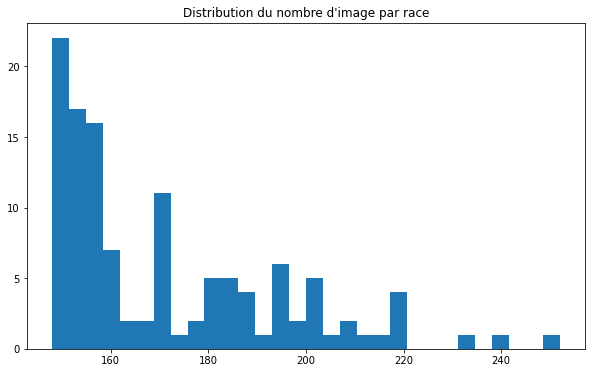

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(img_per_breed, bins=30)
plt.title('Distribution du nombre d\'image par race')
if env == 'local':
    plt.savefig(save_path + 'distri_img.png')
plt.show()

Nous constatons que la majorité des races comportent entre 140 et 160 photos.  
De plus nous n'avons pas de problématique d'une race qui ne comporterai pas suffisemment de photos.

In [8]:
print("Nombre minimum d'images dans une classe : {}".format(min(img_per_breed)))

Nombre minimum d'images dans une classe : 148


## 2.5 Echantillon d'images

In [9]:
def show_images_sample(nb_breed_to_show):
    '''show 4 firsts images of nb_breed_to_show breed choosen randomly'''

    nb_breed_to_show = int(nb_breed_to_show)

    plt.figure(figsize=(16,nb_breed_to_show*4))

    # fig.suptitle(breed, fontsize=20)
    for i in range(nb_breed_to_show):
        breed = random.choice(breed_list)
        img_dir = ini_img_dir + breed
        images = os.listdir(img_dir)[:4] # select 4 first images names

        for image_nb in range(4):
            plt.subplot(nb_breed_to_show, 4, (image_nb+1)+4*(i))
            img = mpimg.imread(img_dir + '/' + images[image_nb])
            plt.imshow(img)
            if image_nb == 0: # title only one the 1st image
                plt.title(breed)
            plt.axis('off')

    if env == 'local':
        plt.savefig(save_path + 'sample.png')

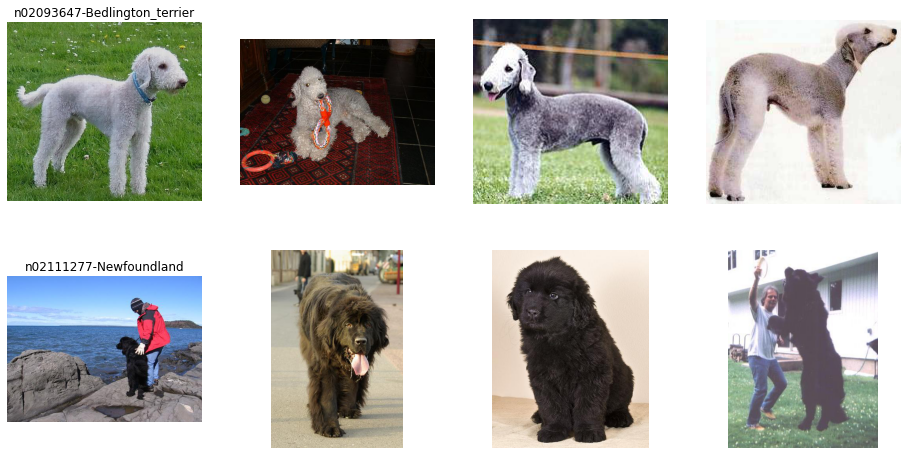

In [10]:
show_images_sample(2)

## 2.6 Filtre images corrompues

Nous travaillons avec de nombreuses données d'images du monde réel, les images corrompues sont un phénomène courant.  
Filtrons les images mal encodées qui ne comportent pas la chaîne "JFIF" dans leur en-tête.

Déterminons tout d'abord si nous avons des images corrompues.  

In [11]:
def filter_corrupted(initial_path, remove=False):
    num_skipped = 0
    for folder_name in os.listdir(initial_path):
        folder_path = os.path.join(initial_path, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                if remove:
                    os.remove(fpath)

    print("%d images corrompues" % num_skipped)

In [12]:
if env == 'local':
    filter_corrupted(ini_img_dir)

10 images corrompues


Si ces images perturbent notre apprentissage ou préprocessing nous pourrons les supprimer.

# 3. Preprocessing

## 3.1 Resize / crop


Nous allons commencer par définir des fonctions permettant de changer la taille de nos images et de les recadrer grâces aux bounding box fournies avec le dataset.

In [13]:
def resize_img(img_path, height=height, width=width, bnd_box_annotations_path=None, method='pillow'):
    '''load and resize one image to height x width pixels return the image

    Parameters
    ------------------------------
    img_path :str
    bnd_box_annotations_path : str
        If bnd_box_annotations_path!=None it will select the proper box and then crop the image before the resize
    img_path : str
        image path and annotations must have the same subdirectories and files names (except for file extension)
    height, width : int
    method : str
        method could use opencv (as cv) instead of pillow (import Image)
    '''
    if method == 'opencv':
        img = cv.imread(img_path, cv.IMREAD_UNCHANGED)
    else:
        img = Image.open(img_path) # pillow library

    # this part extrat the bounding box dimensions from annotation folder
    if bnd_box_annotations_path!=None:
        path_no_extension = os.path.splitext(img_path)[0]
        file_name = os.path.split(path_no_extension)[1]
        # take the breed from the initial image path
        breed = os.path.split(os.path.split(path_no_extension)[0])[1]
        img_annotation_dir = bnd_box_annotations_path + '{}/{}'.format(breed, file_name)
        tree = ET.parse(img_annotation_dir)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)

        if method == 'opencv':
            img = img[ymin:ymax, xmin:xmax]
        else:
            img = img.crop((xmin, ymin, xmax, ymax))

    if method == 'opencv':
        img = cv.resize(img, (height, width), interpolation=cv.INTER_LINEAR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    else:
        img = img.convert('RGB')
        img = img.resize((height, width))
    return img

In [14]:
def random_img(img_dir=ini_img_dir):
    '''return a random image path from our dataset'''
    breed_list = os.listdir(img_dir)
    breed = random.choice(breed_list)
    breed_path = img_dir + breed
    image = random.choice(os.listdir(breed_path))
    image_path = breed_path + '/' + image
    return image_path

In [15]:
def show_dif_size_img(ini_img_dir=ini_img_dir):

    image_path = random_img(ini_img_dir)

    fig = plt.figure(figsize=(16, 6))
    fig.suptitle('Images after size preprocessing', fontsize=16)

    # for i in range(3):
    plt.subplot(1, 3, 1)
    img = mpimg.imread(image_path)
    plt.title("Original shape : {}".format(img.shape))
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    img = resize_img(image_path, method='opencv')
    plt.title("Resized shape : {}".format(img.shape))
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    img = resize_img(image_path, bnd_box_annotations_path=bnd_box_annotations_path, method='opencv')
    plt.title("Cropped and resized shape : {}".format(img.shape))
    plt.imshow(img)
    plt.axis('off')
    
    if env == 'local':
        plt.savefig(save_path + 'size_preprocessing.png')

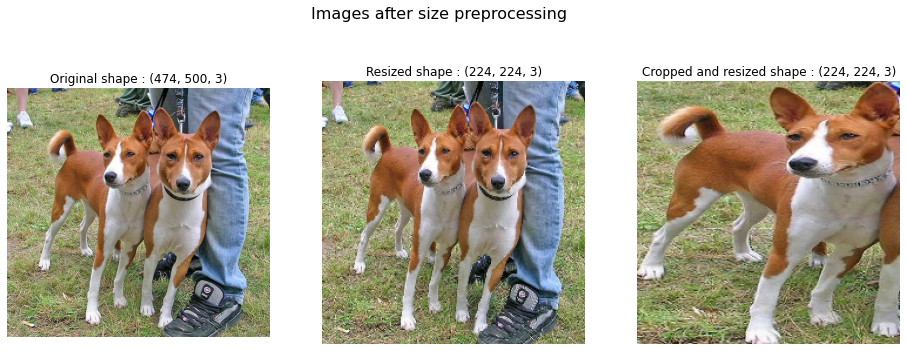

In [16]:
show_dif_size_img()

## 3.2 whitening

Dans les images naturelles, les pixels ont tendance à être corrélés avec leurs voisins.  
Le whitening supprime ces corrélations.

L'application du whitening PCA a pour effet de normaliser les images pour les écarts naturels.  
Cette normalisation améliore la précision des comparaisons que nous effectuons entre différentes parcelles d'image en utilisant la distance euclidienne.  
La distance entre les taches blanchies est une bien meilleure mesure de leur similitude que la distance entre les taches non blanchies. 

Nous utilisons d'abord l'ACP pour trouver les directions de variance et projeter les données dans ces directions.  
Ensuite, nous pouvons facilement normaliser la variance. 

L'étape de blanchiment effectue une extraction de caractéristiques qui, dans cet exemple, donne à la comparaison de distance une certaine invariance par rapport aux changements de luminosité.

<img src="..\img\pixel_4_5_correlation.png" width="400px"><img src="..\img\pixel_4_5_correlation_after_whiten.png" width="400px">    

Nous utiliserons le whitening à partir de la méthode Keras permettant de faire de la data augmentation.

## 3.3 histogram equalization

L'histogramme d'une image numérique est une courbe statistique représentant la répartition de ses pixels selon leur intensité.  
Commençons par regarder une image en particulier.

Nous allons transformer l'image dans différents codages couleurs.  
Le système de codage YUV est créé depuis une source RVB. Il est codé en trois composantes : 
- Y représente la luminance (informations de luminosité) 
- U et V sont des données de chrominance (informations de couleur).  
Ce format nous permet de visualiser au mieux l'histogramme pour les 3 dimensions.

**Egalisation**  
On constate régulièrement des pics importants de l'histogram.  
Dans le cadre d'une bonne égalisation (amélioration du contraste), il est nécessaire de répartir la lumière dans tout le spectre de l'image.

Nous utiliserons OpenCV pour l'égalisation.  
L'intérêt de convertir l'image dans l'espace colorimétrique YUV est de pouvoir agir sur le canal "luminance" (Y) indépendamment des autres canaux de chrominance.  
Nous allons donc réaliser l'égalisation sur ce seul canal Y

In [17]:
def equalize(img):
    '''initial and final image in RGB'''
    img_YUV = cv.cvtColor(img,cv.COLOR_RGB2YUV)
    img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
    img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
    return img_equ

In [18]:
def show_histo_img(img_dir=ini_img_dir):

    image_path = random_img(img_dir)

    fig = plt.figure(figsize=(16, 8))
    fig.suptitle('Images after equalization preprocessing', fontsize=16)
    fig.tight_layout()

    # for i in range(3):
    plt.subplot(2, 3, 1)
    img = mpimg.imread(image_path)
    plt.title("Original image")
    plt.imshow(img)

    plt.subplot(2, 3, 2)
    plt.title("Original image YUV")
    plt.imshow(cv.cvtColor(img,cv.COLOR_RGB2YUV))

    plt.subplot(2, 3, 3)
    plt.title("Original image histogram")
    vals = img.mean(axis=2).flatten()
    # plot histogram with 255 bins
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])

    plt.subplot(2, 3, 4)
    img = equalize(img)
    plt.title("Equalized image")
    plt.imshow(img)

    plt.subplot(2, 3, 5)
    plt.title("Equalized image YUV")
    plt.imshow(cv.cvtColor(img,cv.COLOR_RGB2YUV))

    plt.subplot(2, 3, 6)
    plt.title("Equalized image histogram")
    vals = img.mean(axis=2).flatten()
    # plot histogram with 255 bins
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])

    plt.axis('off')

    if env == 'local':
        plt.savefig(save_path + 'equalisation.png')

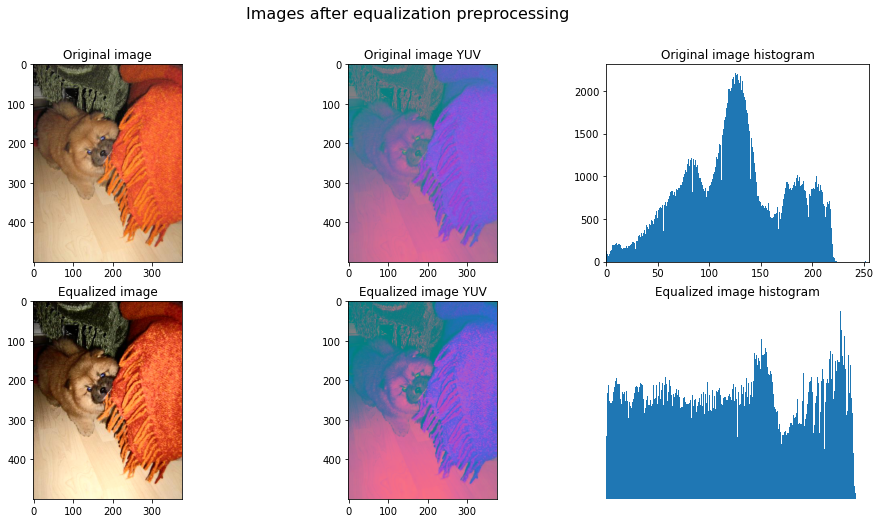

In [19]:
show_histo_img()

## 3.4 data augmentation

Le risque sur ce type de dataset comportant peu de données (20 000 images) est de sur-entrainer notre modèle.  
Il ne pourra pas développer des règles de décisions pouvant être généralisé à de nouvelles données.  
Il faut donc augmenter la quantité de data et pour cela, nous allons utiliser la Data Augmentation.

L'objectif de la data augmentation est d'augmenter artificiellement la quantité de données en leur appliquant une transformation aléatoire.  
Pour cela, Keras mets à disposition la méthode ImageDataGenerator qui permet de faire à la fois du mirroring, de la rotation, des zoom de manière aléatoire !

In [20]:
val_split = .2

In [21]:
def data_generator(val_split, zca_whitening=False, zca_epsilon=1e-06, normalize=False, preprocessing_function=None):
        '''return a ImageDataGenerator objetc from keras'''
        if normalize:
                rescale = 1./255
        else:
                rescale = None   

        data_gen = ImageDataGenerator(
                rescale=rescale,
                shear_range=0.2,
                rotation_range=30,
                zoom_range=0.1,
                brightness_range=[0.9,1.1],
                horizontal_flip=True,
                validation_split=val_split,
                zca_whitening=zca_whitening,
                zca_epsilon=zca_epsilon,
                preprocessing_function=preprocessing_function,
                )
        return data_gen

In [22]:
# We create 2 differents objects for the data augmentation
data_gen = data_generator(val_split, normalize=True)
data_gen_wh = data_generator(val_split, zca_whitening=True, normalize=True)

C:\Users\Admin\miniconda3\envs\env_p6\lib\site-packages\keras_preprocessing\image\image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [23]:
def show_data_gen(data_gen, img_dir=ini_img_dir):
    image_path = random_img(img_dir)
    img = mpimg.imread(image_path)

    # Convert test img to array
    x = keras.preprocessing.image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    fig = plt.figure(figsize=(12,10))
    fig.suptitle('Data Augmentation with Keras', fontsize=16)

    for i, batch in zip(range(12), data_gen.flow(x, batch_size=1)):
        ax = fig.add_subplot(3,4,i+1)
        ax.imshow(keras.preprocessing.image.array_to_img(batch[0]))
        plt.axis('off')

    if env == 'local':
        plt.savefig(save_path + 'distri_img.png')
    plt.show()

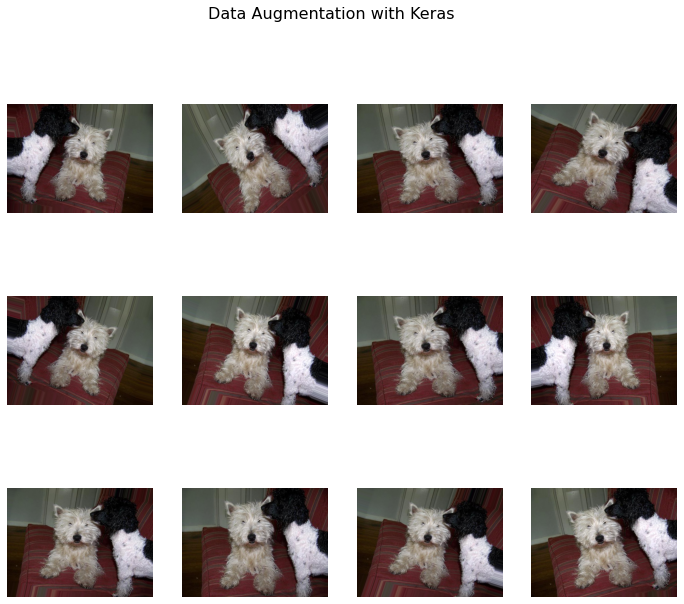

In [24]:
show_data_gen(data_generator(val_split))

## 3.5 Preprocessing final

Nous allons créer une fonction permettant de réaliser le préprocessing global.

Nous y inclueront une étape de mélange pour éviter que toutes nos races se suivents.

Les modèles de machine learning prennent en entrée des variables numériques de type float.  
Il faut donc modifier les types de nos données X et convertir nos données à prédire y.

Pour y nous allons donc utiliser un simple LabelEncoder pour les convertir.

In [25]:
def shuffle_Xy(X, y):
    # Using np.shuffle
    index = np.arange(X.shape[0])
    np.random.seed(42)
    # Shuffle the space
    np.random.shuffle(index)
    # Apply to X and y in same order
    X = X[index]
    y = y[index]
    return X, y

def change_type(X):
    # Change X type 
    return X.astype(np.float32)

def enc_label(y):
    # Encode y data
    encoder = LabelEncoder()
    encoder.fit(y)
    return encoder.transform(y)

In [26]:
def preprocessing_img(img_folder=ini_img_dir, height=height, width=width, bbx_annot=None, equalization=True, nb_breed=None):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. 
    Loading, resizing, equalization and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    return X, y (numpy array)

    Parameters
    ---------------------------------------------------
    folder : str
        Initial folder with images
    width : integer
        width of the image to be reached for resizing
    height : integer
        height of the image to be reached for resizing
    bbx_annot : str
        path for annotation folder for bounding box crop
    equalization : bool
        activate or not the equalization
    nb_breed : int
        number of breeds to treat
        by default len(os.listdir(img_folder))
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    if nb_breed == None:
        nb_breed = len(os.listdir(img_folder))
        
    breeds = os.listdir(img_folder)[:nb_breed]
    for breed in breeds:
        for image_name in os.listdir(img_folder + "/" + breed):

            img_path = img_folder + "/" + breed + "/" + image_name

            # Resize image
            img = resize_img(img_path, height, width, bnd_box_annotations_path=bbx_annot, method='opencv')
            
            # Equalization
            if equalization:
                img = equalize(img)
            
            # Convert modified img to array
            img_array = keras.preprocessing.image.img_to_array(img)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])

    # Convert in numpy array
    X = np.array(img_list)
    y = np.array(labels)

    X, y = shuffle_Xy(X, y)
    X = change_type(X)
    y = enc_label(y)

    X, y = shuffle_Xy(X, y)
    X = change_type(X)
    y = enc_label(y)
    
    return X, y

In [27]:
# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_img(img_folder=ini_img_dir, height=height, width=width, bbx_annot=None, equalization=True, nb_breed=nb_breed)

preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))

# we'll try also images cropped with annotations
start_time = timeit.default_timer()

X_crop, y_crop = preprocessing_img(img_folder=ini_img_dir, height=height, width=width, bbx_annot=bnd_box_annotations_path, equalization=True, nb_breed=nb_breed)

preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing (cropped):")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y_crop)))
print("Shape of images np.array : {}"\
     .format(X_crop.shape))
print("Total time : {:.2f}s".format(preprocess_time))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 738
Shape of images np.array : (738, 224, 224, 3)
Total time : 3.24s
--------------------------------------------------
Execution time for preprocessing (cropped):
--------------------------------------------------
Number of images preprocessed : 738
Shape of images np.array : (738, 224, 224, 3)
Total time : 6.59s


In [28]:
# np.savez_compressed('X_' + str(nb_breed) + '.npz', X)

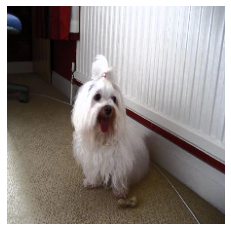

In [29]:
# sample
plt.imshow(keras.preprocessing.image.array_to_img(X[random.randint(0, 100)]))
plt.axis('off')
plt.show()

A présent, nous pouvons créer les sets d'entrainement et de test qui serviront respectivement à l'entrainement de nos modèles et à son test final.  
Le set de validation quant à lui sera créé directement dans le générateur Keras.

In [30]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
x_train_crop, x_test_crop, y_train_crop, y_test_crop = train_test_split(X_crop, y_crop, test_size = 0.15, random_state = 42)

del X, y, X_crop, y_crop

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
Train set size =  627
Test set size =  111



# 4. CNN spécifique


Nous allons tout d'abord créer un réseau de neuronne convolutif entier avant de l'entrainer et de le tester.  
Celui ci est constitué d'un couche d'entrées avec notre dataset, de multiples couches cachées et d'une couche de sortie qui sert de classifier.  
Des poids sont affectés aux liens entre les différentes couches pendant la pahse d'apprentissage du modèle.

<img src="../img/iHW2o.jpg" width="450px">       



## 4.1 Création du model

Nous allons ici initialiser un premier modèle de réseau de neurones à convolution en imbriquant plusieurs couches ou layer :

- **Convolution** : Son but est de repérer la présence d'un ensemble de features dans les images reçues en entrée.  
  Pour cela, on réalise un filtrage par convolution.  
<img src="../img/1_qtinjiZct2w7Dr4XoFixnA.gif" width="500px">       
- **Pooling** : L'opération de pooling consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes.  
<img src="../img/1_gaD6SJ6kQNVOclE_WkwLNQ.png" width="350">
- **Correction ReLU** : La couche de correction ReLU remplace toutes les valeurs négatives reçues en entrées par des zéros.  
  Elle joue le rôle de fonction d'activation.  
<img src="../img/1_njuH4XVXf-l9pR_RorUOrA.png" width="350px">       

- **Fully connected** : Ce type de couche reçoit un vecteur en entrée et produit un nouveau vecteur en sortie.  
  Pour cela, elle applique une combinaison linéaire puis éventuellement une fonction d'activation aux valeurs reçues en entrée.
- **DropOut** : La méthode du dropout consiste à « désactiver » des sorties de neurones aléatoirement pour éviter le sur-entraînement.

Pour notre modèle, nous allons tester une architecture simple, assez peu profonde qui nous servira de baseline pour les prochains modèles.  
Nous allons donc implémenter uniquement 3 couches de convolution.


In [31]:
def make_model(nb_breed=nb_breed, height=height, width=width, optimizer='adam',metrics=["accuracy"], summary=True):
    '''Create a simple sequential model

    parameters
    ------------------
    nb_breed : int
        number of breed to classify
    height, width : int
    optimizer : str
        from tf.keras.optimizers
    metrics : list
    summary : Bool
    '''
    K.clear_session()
    model = Sequential()
    # Convolution layer
    model.add(Conv2D(filters=16,
                    kernel_size=(3,3), 
                    padding='same',
                    use_bias=False,
                    input_shape=(height, width,3))) # we don't need to add an input because of this line
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation('relu'))
    # Pooling layer
    model.add(MaxPooling2D(pool_size=(4, 4),
                        strides=(4, 4),
                        padding='same'))
    # DropOut
    model.add(Dropout(0.2))
    # Second convolution layer
    model.add(Conv2D(filters=32,
                    kernel_size=(3,3), 
                    padding='same',
                    use_bias=False))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
    model.add(Dropout(0.2))
    # Third convolution layer
    model.add(Conv2D(filters=64,
                    kernel_size=(3,3), 
                    padding='same',
                    use_bias=False))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation('relu'))
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, activation='relu'))

    if nb_breed == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = nb_breed

    model.add(Dropout(0.2))
    model.add(Dense(units, activation=activation))

    if nb_breed == 2:
        loss="binary_crossentropy"
    else:
        loss="sparse_categorical_crossentropy"

    # Compile the CNN Model
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    if summary:
        model.summary()
    return model

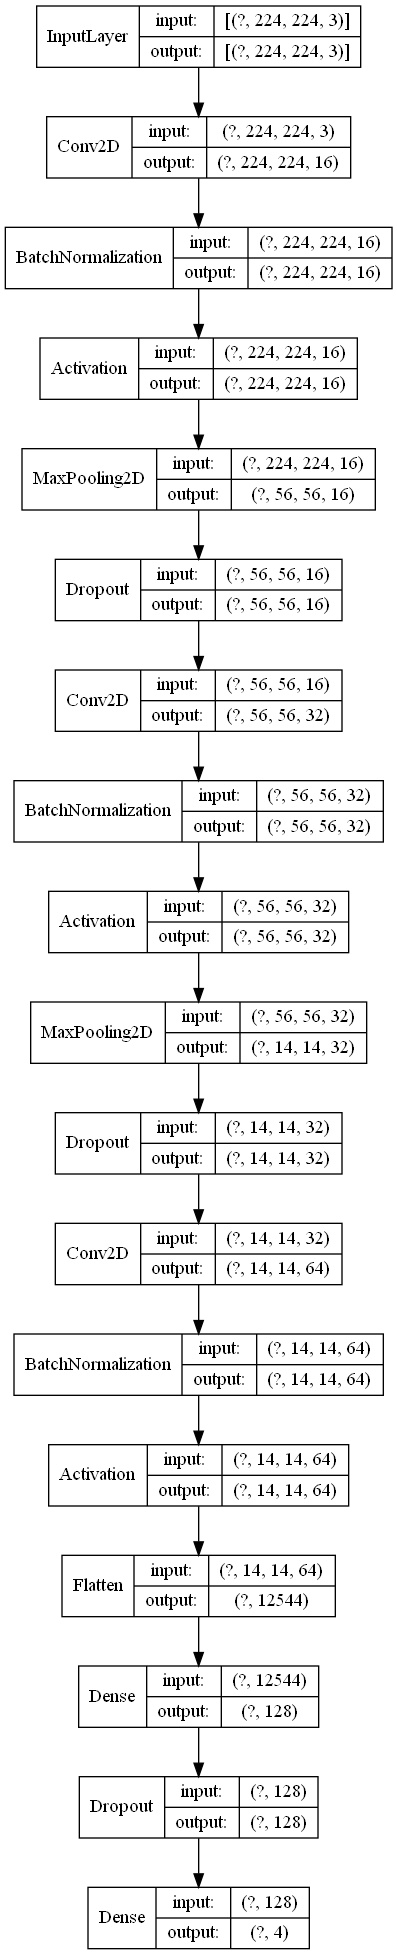

In [32]:
model = make_model(optimizer='adam',metrics=["accuracy"], summary=False)
if env == 'local':
    display(plot_model(model,
        to_file=save_path + 'model_scratch.png',
        show_shapes=True,
        show_layer_names=False))

## 4.2 Evaluation

Nous utiliserons pour l'évaluation la "Loss-Function" et l'"Accuracy".  
Il s'agit de façon équivalente de diminuer la première ou d'augmenter la seconde.

<!-- Nous allons également définir le Score F1 qui combine precision et recall :

La précision est utilisée lorsque les vrais positifs et les vrais négatifs sont plus importants tandis que le score F1 est utilisé lorsque les faux négatifs et les faux positifs sont cruciaux
La précision peut être utilisée lorsque la distribution des classes est similaire, tandis que le score F1 est une meilleure mesure lorsqu'il existe des classes déséquilibrées comme dans le cas ci-dessus.

Dans la plupart des problèmes de classification de la vie réelle, une distribution de classe déséquilibrée existe et le score F1 est donc une meilleure mesure pour évaluer notre modèle. -->

In [33]:
# score_f1_activate = False

# if score_f1_activate:

#     def recall_m(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#         recall = true_positives / (possible_positives + K.epsilon())
#         return recall

#     def precision_m(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#         precision = true_positives / (predicted_positives + K.epsilon())
#         return precision

#     def f1_m(y_true, y_pred):
#         precision = precision_m(y_true, y_pred)
#         recall = recall_m(y_true, y_pred)
#         return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [34]:
def plot_history_scores(dict_history, first_score, second_score=None):
    '''plot scores from history dic created by keras'''
    with plt.style.context('seaborn-whitegrid'):

        # summarize history for accuracy
        if second_score:
            fig = plt.figure(figsize=(14, 6))
            plt.subplot(1, 2, 1)
        else:
            fig = plt.figure(figsize=(8, 6))

        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=14)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        if second_score:
            # summarize history for loss
            plt.subplot(1, 2, 2)
            plt.plot(dict_history.history[second_score], color="g")
            plt.plot(dict_history.history['val_' + second_score],
                    linestyle='--', color="orange")
            plt.title('CNN model ' + second_score, fontsize=14)
            plt.ylabel(second_score)
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')

        if env == 'local':
            plt.savefig(save_path + 'score_graph.png')

        plt.show()

## 4.3 Entrainement

Nous allons maintenant entrainer et évaluer notre modèle.  
Nous testerons 2 optimizers différents ainsi que l'effet du whitening sur nos résultats.

In [36]:
score_dic = {}

def model_eval_store(model, x_test, y_test, dic, model_name, time, history):

    test_loss, test_acc = model.evaluate(x_test, y_test)  # returns loss and metrics
    print("loss: %.2f" % test_loss)
    print("acc: %.2f" % test_acc)
    
    dic[model_name] = [round(max(history.history['accuracy']), 2), # train
        round(max(history.history['val_accuracy']), 2), # val
        round(test_acc, 2), # test
        round(time, 2)] # time

In [37]:
def model_tester(x_train, y_train, x_test, y_test, optimizer, data_gen, model_name, model=None, fine_tuning=False):
        '''automation of the model creation, compiling, fitting and evaluate'''
        start_time = timeit.default_timer()

        if model is None:
                model = make_model(optimizer=optimizer,metrics=["accuracy"], summary=False)

        train_ds = data_gen.flow(
                x_train, y_train,
                batch_size=batch_size,
                subset='training')

        val_ds = data_gen.flow(
                x_train, y_train,
                batch_size=batch_size,
                subset='validation')
        
        callbacks = []
        early_stopping_monitor = EarlyStopping(patience=5)
        callbacks.append(early_stopping_monitor)
        if fine_tuning:
                lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
                callbacks.append(lr_reduce)

        history = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=epochs,
                callbacks = callbacks,
                verbose=2)

        convergence_time = timeit.default_timer() - start_time

        plot_history_scores(
                dict_history = history, 
                first_score = "accuracy")

        model_eval_store(model, x_test, y_test, score_dic, model_name, convergence_time, history)

        return model

Amélioration : sortir le plot du tester et retourner l'history et le conv time.  
le plot pourrait afficher tous les history sur le meme graph

Epoch 1/20
16/16 - 12s - loss: 3.4808 - accuracy: 0.2649 - val_loss: 1.3815 - val_accuracy: 0.3040
Epoch 2/20
16/16 - 12s - loss: 1.3629 - accuracy: 0.3586 - val_loss: 1.3741 - val_accuracy: 0.3280
Epoch 3/20
16/16 - 12s - loss: 1.3271 - accuracy: 0.3606 - val_loss: 1.3858 - val_accuracy: 0.2880
Epoch 4/20
16/16 - 12s - loss: 1.3046 - accuracy: 0.4064 - val_loss: 1.4147 - val_accuracy: 0.2800
Epoch 5/20
16/16 - 12s - loss: 1.2683 - accuracy: 0.4382 - val_loss: 1.4151 - val_accuracy: 0.2800
Epoch 6/20
16/16 - 12s - loss: 1.1969 - accuracy: 0.4841 - val_loss: 1.5468 - val_accuracy: 0.2800
Epoch 7/20
16/16 - 15s - loss: 1.1909 - accuracy: 0.4741 - val_loss: 1.5996 - val_accuracy: 0.2800


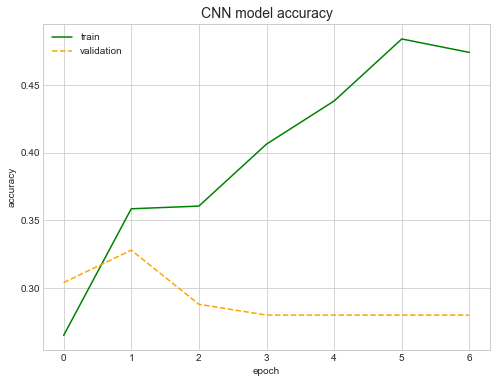

4/4 [==============================] - 0s 55ms/step - loss: 52.1143 - accuracy: 0.2523
loss: 52.11
acc: 0.25
Epoch 1/20
16/16 - 15s - loss: 3.6650 - accuracy: 0.3028 - val_loss: 1.3568 - val_accuracy: 0.3520
Epoch 2/20
16/16 - 13s - loss: 1.2681 - accuracy: 0.4124 - val_loss: 1.3287 - val_accuracy: 0.4480
Epoch 3/20
16/16 - 13s - loss: 1.2356 - accuracy: 0.4243 - val_loss: 1.3476 - val_accuracy: 0.2800
Epoch 4/20
16/16 - 13s - loss: 1.1674 - accuracy: 0.4482 - val_loss: 1.3599 - val_accuracy: 0.3200
Epoch 5/20
16/16 - 15s - loss: 1.1362 - accuracy: 0.4602 - val_loss: 1.4048 - val_accuracy: 0.2800
Epoch 6/20
16/16 - 12s - loss: 1.0793 - accuracy: 0.5060 - val_loss: 1.4019 - val_accuracy: 0.2880
Epoch 7/20
16/16 - 12s - loss: 1.0765 - accuracy: 0.5120 - val_loss: 1.5364 - val_accuracy: 0.2800


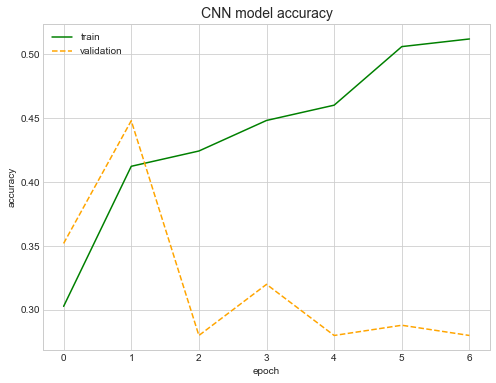

4/4 [==============================] - 0s 54ms/step - loss: 47.1346 - accuracy: 0.4414
loss: 47.13
acc: 0.44


C:\Users\Admin\miniconda3\envs\env_p6\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Admin\miniconda3\envs\env_p6\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
16/16 - 12s - loss: 2.8318 - accuracy: 0.3287 - val_loss: 1.3566 - val_accuracy: 0.3680
Epoch 2/20
16/16 - 13s - loss: 1.3724 - accuracy: 0.4064 - val_loss: 1.3650 - val_accuracy: 0.2800
Epoch 3/20
16/16 - 13s - loss: 1.1919 - accuracy: 0.4721 - val_loss: 1.4754 - val_accuracy: 0.2800
Epoch 4/20
16/16 - 11s - loss: 1.0940 - accuracy: 0.4980 - val_loss: 1.4604 - val_accuracy: 0.2800
Epoch 5/20
16/16 - 12s - loss: 1.1128 - accuracy: 0.5398 - val_loss: 1.5642 - val_accuracy: 0.2800
Epoch 6/20
16/16 - 13s - loss: 1.0440 - accuracy: 0.5478 - val_loss: 1.7452 - val_accuracy: 0.2800


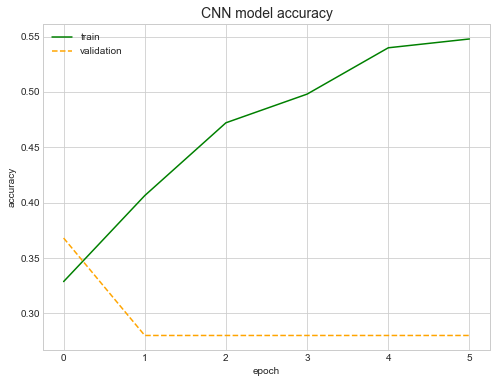

4/4 [==============================] - 0s 65ms/step - loss: 82.8550 - accuracy: 0.2973
loss: 82.85
acc: 0.30
Epoch 1/20
16/16 - 13s - loss: 6.1562 - accuracy: 0.3207 - val_loss: 1.3662 - val_accuracy: 0.2800
Epoch 2/20
16/16 - 15s - loss: 1.3473 - accuracy: 0.3845 - val_loss: 1.3991 - val_accuracy: 0.2800
Epoch 3/20
16/16 - 14s - loss: 1.2991 - accuracy: 0.4124 - val_loss: 1.8318 - val_accuracy: 0.2800
Epoch 4/20
16/16 - 13s - loss: 1.2748 - accuracy: 0.4303 - val_loss: 1.5247 - val_accuracy: 0.2800
Epoch 5/20
16/16 - 13s - loss: 1.2316 - accuracy: 0.4522 - val_loss: 1.4572 - val_accuracy: 0.2800
Epoch 6/20
16/16 - 13s - loss: 1.1447 - accuracy: 0.4940 - val_loss: 1.7602 - val_accuracy: 0.2800


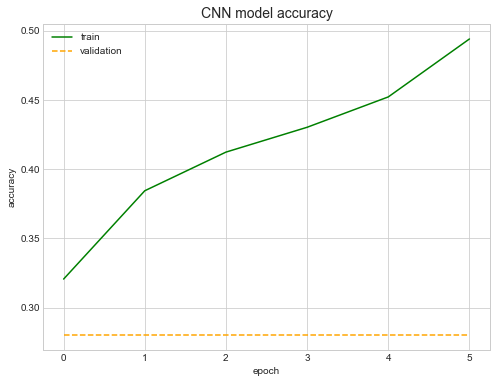

4/4 [==============================] - 0s 63ms/step - loss: 79.7187 - accuracy: 0.2072
loss: 79.72
acc: 0.21


In [38]:
# baseline
model_tester(x_train, y_train, x_test, y_test,
    optimizer='adam',
    data_gen=data_gen,
    model_name='baseline')

# images copped
model_tester(x_train_crop, y_train_crop, x_test_crop, y_test_crop,
    optimizer='adam',
    data_gen=data_gen,
    model_name='cropped')

# testing whitening
model_tester(x_train, y_train, x_test, y_test,
    optimizer='adam',
    data_gen=data_gen_wh,
    model_name='whitening')

# testing a different optimizer
model_tester(x_train, y_train, x_test, y_test,
    optimizer='RMSprop',
    data_gen=data_gen,
    model_name='RMSprop')

In [39]:
def plot_history(score_dic=score_dic, fig_name=None):
    labels = score_dic.keys()

    train_accuracy = [score[0] for score in score_dic.values()]
    val_accuracy = [score[1] for score in score_dic.values()]
    test_accuracy = [score[2] for score in score_dic.values()]
    time = [score[3] for score in score_dic.values()]

    width_plt = 0.3  # the width of the bars
    x = np.arange(len(labels))  # the label locations
    graph_width = 4 * len(score_dic)
    with plt.style.context('seaborn-whitegrid'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(graph_width,8))


        train = ax1.bar(x - width_plt, train_accuracy, width_plt, label='Train')
        val = ax1.bar(x , val_accuracy, width_plt, label='Val')
        test = ax1.bar(x + width_plt, test_accuracy, width_plt, label='Test')

        time_model = ax2.bar(x, time, 2*width_plt, label='Time')

        ax1.set_title('Accuracy (higher is better)')
        ax1.set_ylabel('Scores')
        ax1.set_xticks(x)
        ax1.set_xticklabels(labels)
        ax1.legend()

        ax2.set_title('Time (lower is better)')
        ax2.set_ylabel('Seconds')
        ax2.set_xticks(x)
        ax2.set_xticklabels(labels)

        if env == 'local' and fig_name is not None:
            plt.savefig(save_path + fig_name + '.png')


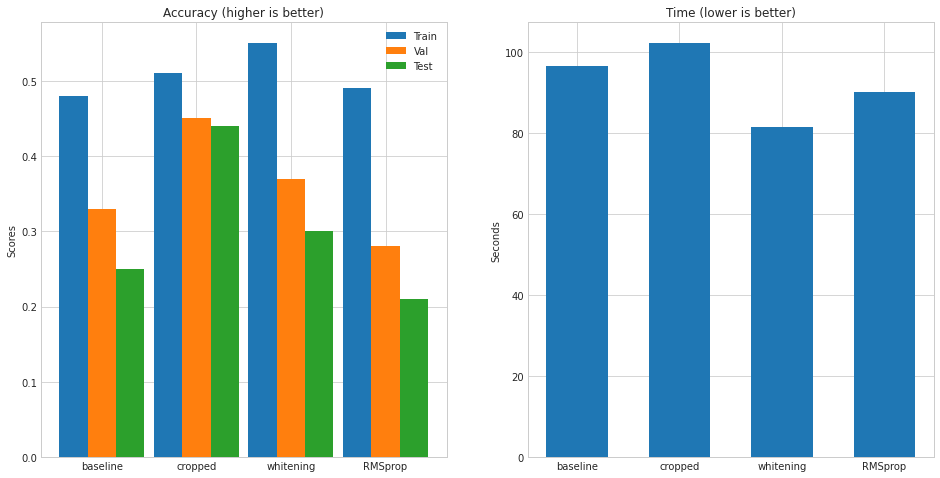

In [40]:
plot_history(score_dic, 'spe_model')

In [41]:
# # Run inference on new data

# img = keras.preprocessing.image.load_img(
#     "PetImages/Cat/6779.jpg", target_size=image_size
# )
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# predictions = model.predict(img_array)
# score = predictions[0]
# print(
#     "This image is %.2f percent cat and %.2f percent dog."
#     % (100 * (1 - score), 100 * score)
# )

In [42]:
# freeing memory
del x_train_crop, x_test_crop, y_train_crop, y_test_crop

# 5. Transfert learning

Nous allons maintenant tester des modèles pré-entrainés et vérifier si les performances sont meilleures comparées à notre baseline.

## 5.1 VGG16 

Le premier modèle testé sera VGG16.  
VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 fully-connected. 

<img src="../img/15209905022025_vgg-16-flat.png" width="800px">    

Chargeons le modèle de base pré-entrainé de Keras mais sans les couches fully-connected.    
Nous allons ajouter notre propre classifier final.

In [43]:
K.clear_session()

inputs = keras.Input(shape=(height, width, 3))
model_vgg16 =  tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    pooling='avg'
)
for layer in model_vgg16.layers[-2:]:
    print(layer)

On remarque dans les layers importés du modèle que la dernière couche importée est une couche GlobalAveragePooling2D. 

Nous allons donc ajouter une couche fully connected, un DropOut et enfin le classifier dans un nouveau modèle.

In [44]:
def make_model_TL(model,model_name=None, out_dense=128, dropout=0.2, keras_tuner=False, hp=None ):

      # For imported layers we'll keep the weights
      for layer in model.layers:
            layer.trainable = False

      base_output = model.output

      if not keras_tuner:
            # fully connected
            output = Dense(out_dense, activation='relu')(base_output)
      else:
            # Tune dense units
            hp_units = hp.Int('dense_units',
                              min_value=32,
                              max_value=300,
                              step=32,
                              default=128)

            output = Dense(units=hp_units,
                        activation='relu')(output)
      # dropout
      output = Dropout(dropout)(output)
      # classifier
      output = Dense(nb_breed, activation='softmax')(output)

      # Define new model
      model = keras.Model(inputs=model.input,
                        outputs=output)
      if not keras_tuner:
            model.compile(optimizer="adam",
                              loss="sparse_categorical_crossentropy",
                              metrics=["accuracy"])
      else:
            # Tune learning rate
            hp_learning_rate = hp.Choice(
                  name='learning_rate',
                  values=[1e-2, 1e-3, 1e-4])

            model.compile(
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

      if env == 'local' and model_name is not None:
            display(plot_model(model,
                  to_file=save_path + model_name +'.png',
                  show_shapes=True,
                  show_layer_names=False))
      return model

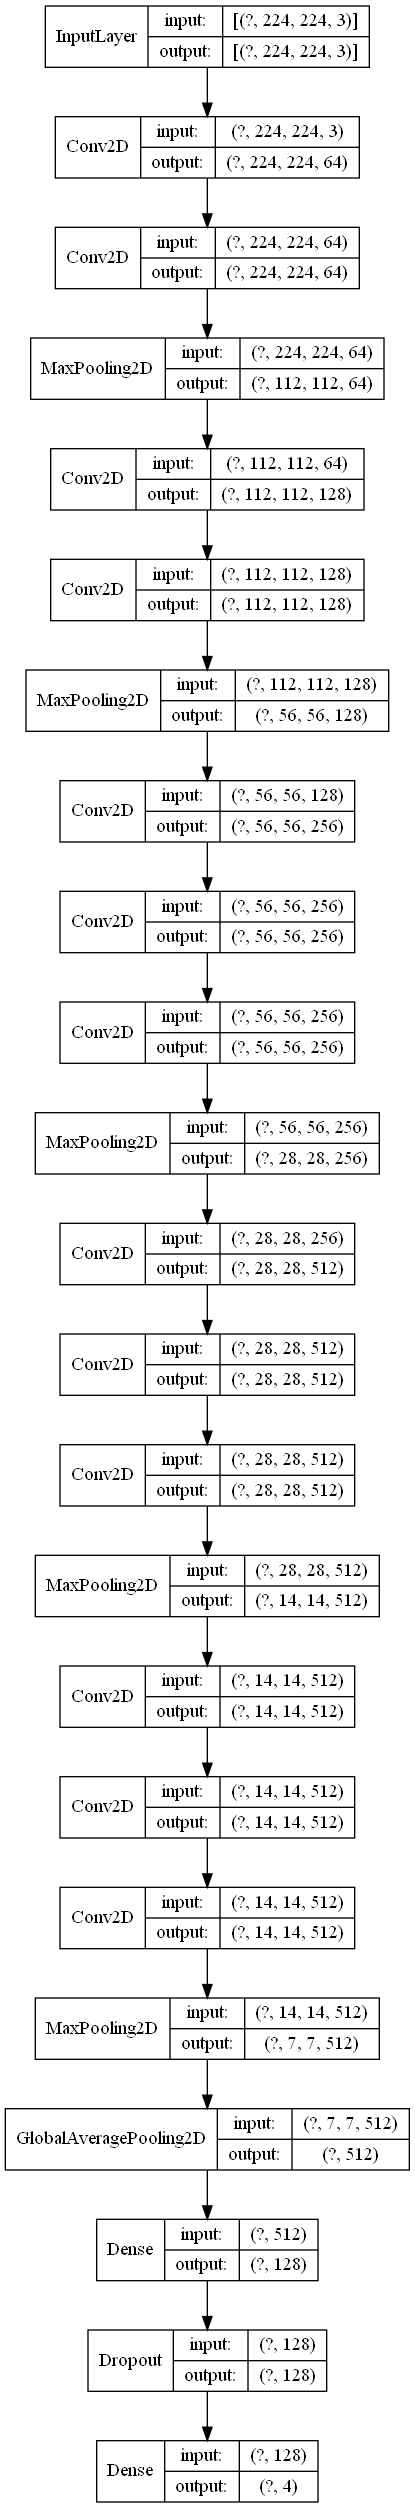

In [45]:
model_vgg16 = make_model_TL(model_vgg16, 'vgg16')
data_gen_vgg16 = data_generator(val_split, normalize=True, preprocessing_function=tf.keras.applications.vgg16.preprocess_input,)

Epoch 1/20
16/16 - 62s - loss: 1.3562 - accuracy: 0.3386 - val_loss: 1.3011 - val_accuracy: 0.4480
Epoch 2/20
16/16 - 66s - loss: 1.2427 - accuracy: 0.4781 - val_loss: 1.2291 - val_accuracy: 0.3920
Epoch 3/20
16/16 - 66s - loss: 1.1216 - accuracy: 0.5498 - val_loss: 1.1354 - val_accuracy: 0.5600
Epoch 4/20
16/16 - 69s - loss: 1.0346 - accuracy: 0.6275 - val_loss: 1.1042 - val_accuracy: 0.5200
Epoch 5/20
16/16 - 66s - loss: 0.9804 - accuracy: 0.6454 - val_loss: 1.0179 - val_accuracy: 0.6080
Epoch 6/20
16/16 - 60s - loss: 0.9041 - accuracy: 0.6853 - val_loss: 0.9717 - val_accuracy: 0.6480
Epoch 7/20
16/16 - 64s - loss: 0.8412 - accuracy: 0.7231 - val_loss: 0.9141 - val_accuracy: 0.6880
Epoch 8/20
16/16 - 64s - loss: 0.8160 - accuracy: 0.7231 - val_loss: 0.8772 - val_accuracy: 0.6960
Epoch 9/20
16/16 - 68s - loss: 0.7623 - accuracy: 0.7311 - val_loss: 0.8265 - val_accuracy: 0.7120
Epoch 10/20
16/16 - 73s - loss: 0.7339 - accuracy: 0.7291 - val_loss: 0.8252 - val_accuracy: 0.7280
Epoch 11/

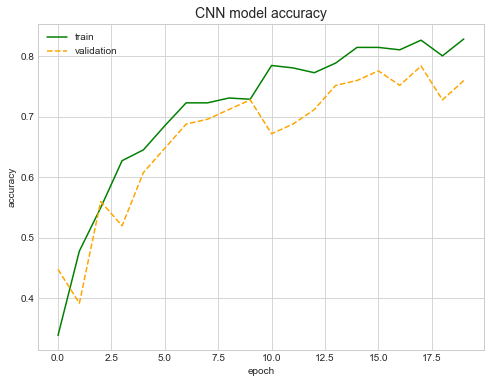

4/4 [==============================] - 8s 2s/step - loss: 12.7691 - accuracy: 0.7477
loss: 12.77
acc: 0.75


In [46]:
model_tester(x_train, y_train, x_test, y_test, 'adam', data_gen_vgg16, 'vgg16', model=model_vgg16)

## 5.2 Xception

Le second modèle testé sera Xception.  
Le modèle Xception est dérivé de l'architecture Inception. Inception a pour but de réduire la consommation de ressources des CNN profonds.  
Il repose sur l'utilisation de blocs de traitement suivants :

<img src="../img/inception_block.png" width="600px">    

Comme précédemment nous chargerons les couches sans les dernières fully-connected.  
Puis nous rajouterons nos couches et notre classifier ainsi qu'un dropout.

In [47]:
K.clear_session()

height_xception = width_xception = 299
inputs = keras.Input(shape=(height_xception, width_xception, 3))

model_xception = keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    pooling='avg'
)

In [48]:
for layer in model_xception.layers[-2:]:
    print(layer)

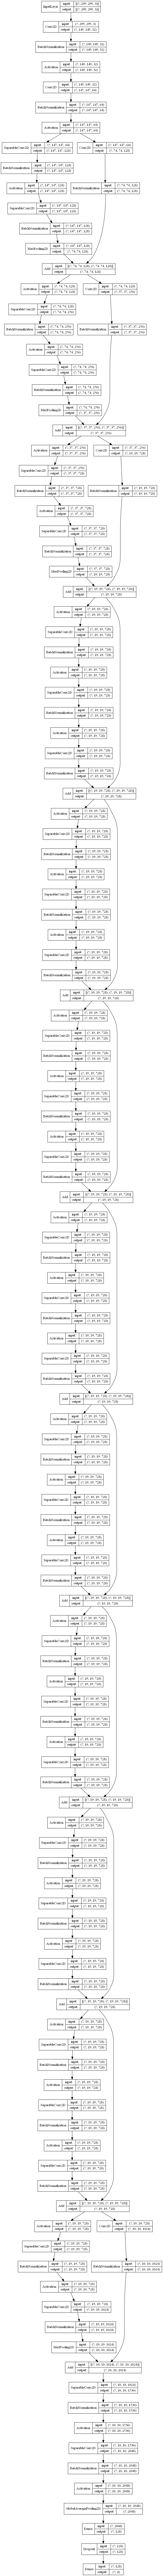

In [49]:
model_xception = make_model_TL(model_xception, 'xception')

Nous allons comme précédemment ajouter une couche fully connected, un DropOut et enfin le classifier dans un nouveau modèle.

In [50]:
data_gen_xception = data_generator(val_split, normalize=True, preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [51]:
# we preprocess images again because Xception need 299*299 images
X, y = preprocessing_img(img_folder=ini_img_dir, height=height_xception, width=width_xception, bbx_annot=None, equalization=True, nb_breed=nb_breed)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
del X, y

Epoch 1/20
16/16 - 60s - loss: 1.3596 - accuracy: 0.3287 - val_loss: 1.3487 - val_accuracy: 0.3280
Epoch 2/20
16/16 - 64s - loss: 1.3025 - accuracy: 0.4064 - val_loss: 1.3234 - val_accuracy: 0.3600
Epoch 3/20
16/16 - 59s - loss: 1.2992 - accuracy: 0.4004 - val_loss: 1.3081 - val_accuracy: 0.3280
Epoch 4/20
16/16 - 59s - loss: 1.2821 - accuracy: 0.4064 - val_loss: 1.3050 - val_accuracy: 0.3520
Epoch 5/20
16/16 - 62s - loss: 1.2730 - accuracy: 0.4482 - val_loss: 1.2736 - val_accuracy: 0.3920
Epoch 6/20
16/16 - 63s - loss: 1.2606 - accuracy: 0.4263 - val_loss: 1.2845 - val_accuracy: 0.3600
Epoch 7/20
16/16 - 68s - loss: 1.2581 - accuracy: 0.4283 - val_loss: 1.2748 - val_accuracy: 0.3600
Epoch 8/20
16/16 - 66s - loss: 1.2463 - accuracy: 0.4343 - val_loss: 1.2814 - val_accuracy: 0.3760
Epoch 9/20
16/16 - 58s - loss: 1.2467 - accuracy: 0.4622 - val_loss: 1.2425 - val_accuracy: 0.3920
Epoch 10/20
16/16 - 60s - loss: 1.2419 - accuracy: 0.4402 - val_loss: 1.2734 - val_accuracy: 0.4160
Epoch 11/

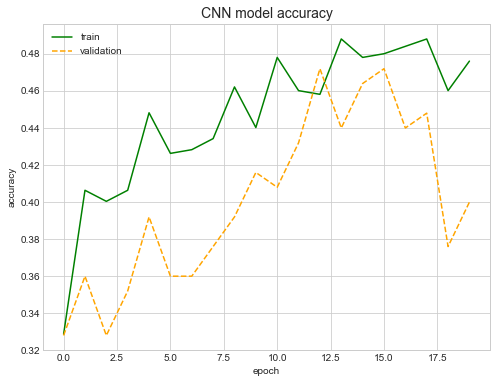

4/4 [==============================] - 7s 2s/step - loss: 72.8128 - accuracy: 0.3694
loss: 72.81
acc: 0.37


In [52]:
model_tester(x_train, y_train, x_test, y_test, 'adam', data_gen_xception, 'xception', model=model_xception)

In [53]:
# freeing memory
del x_train, x_test, y_train, y_test

## 5.3 transfert learning evaluation

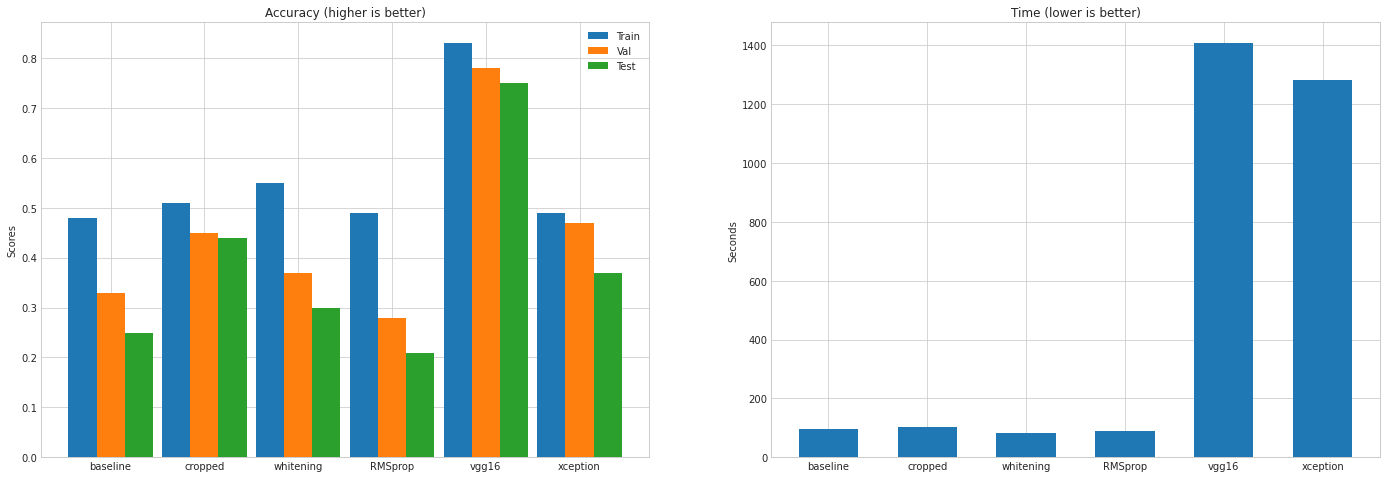

In [54]:
plot_history(score_dic, 'transfert_learning')

On voit bien que les modèle entrainés avec un transfert learning sont bien plus performant que notre modèle spécifique.  

Suite à ces résultats nous choisirons par la suite le modèle VGG16.

In [55]:
# model = ...  # Get model (Sequential, Functional Model, or Model subclass)
# model.save('path/to/location')

# from tensorflow import keras
# model = keras.models.load_model('path/to/location')

# 5.4 Model optimization

Utilisons kerastuner pour améliorer les paramètres de la couche dense que nous avons ajouté au modèle VGG16 de Keras et sélectionner les meilleurs.  
Nous allons également tester plusieurs learning rate.

In [56]:
def model_builder(hp):
    # Load base model
    K.clear_session()

    inputs = keras.Input(shape=(height, width, 3))
    model_vgg16_opt_draft =  keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs,
        pooling='avg'
        )

    for layer in model_vgg16_opt_draft.layers:
        layer.trainable = False
    
    output = model_vgg16_opt_draft.output
    
    # Tune dense units
    hp_units = hp.Int('dense_units',
                      min_value=32,
                      max_value=300,
                      step=32,
                      default=128)

    output = Dense(units=hp_units, 
                        activation='relu')(output)
    
    output = Dropout(0.2)(output)
    
    # Output : new classifier
    output = Dense(nb_breed, activation='softmax')(output)

    # Define new model
    model_vgg16_opt = keras.Model(inputs=model_vgg16_opt_draft.input,
                       outputs=output)
    
    # Tune learning rate
    hp_learning_rate = hp.Choice(
        name='learning_rate',
        values=[1e-2, 1e-3, 1e-4])

    model_vgg16_opt.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    
    return model_vgg16_opt

In [57]:
data_gen_vgg16 = data_generator(val_split, normalize=True, preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# we preprocess images again
X, y = preprocessing_img(img_folder=ini_img_dir, height=height, width=width, bbx_annot=None, equalization=True, nb_breed=nb_breed)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
del X, y

In [58]:
# Tune the learning rate for the optimizer
# Constuct the tuner of kerastuner
tuner = kt.RandomSearch(
    model_builder, 
    objective='val_accuracy',
    max_trials=5)

# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

start_time = timeit.default_timer()

train_ds = data_gen_vgg16.flow(
        x_train, y_train,
        batch_size=batch_size,
        subset='training')

val_ds = data_gen_vgg16.flow(
        x_train, y_train,
        batch_size=batch_size,
        subset='validation')


# Search best params
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("-" * 50)
print("VGG16 Hyperparameters optimization :")
print("-" * 50)
print(f"""
Best learning rate : {best_hps.get('learning_rate')}.\n
Best Dense units : {best_hps.get('dense_units')}.""")

Trial 5 Complete [00h 12m 36s]
val_accuracy: 0.47200000286102295

Best val_accuracy So Far: 0.800000011920929
Total elapsed time: 00h 59m 55s
INFO:tensorflow:Oracle triggered exit
--------------------------------------------------
VGG16 Hyperparameters optimization :
--------------------------------------------------

Best learning rate : 0.01.

Best Dense units : 128.


Une fois les meilleurs paramètres trouvés, on peut construire le modèle avec ses meilleurs hyperparamètres.  
Nous le testerons sur notre dataset pour le comparer aux précédents modèles.

In [60]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.save('vgg16_hypermodel.h5')

In [63]:
model_tester(x_train, y_train, x_test, y_test,
    optimizer='adam',
    data_gen=data_gen_vgg16,
    model_name='vgg16_hypermodel',
    model=hypermodel, save=False)

Epoch 1/20
16/16 - 62s - loss: 1.6684 - accuracy: 0.3167 - val_loss: 1.2649 - val_accuracy: 0.3200
Epoch 2/20
16/16 - 63s - loss: 1.1456 - accuracy: 0.4980 - val_loss: 1.1665 - val_accuracy: 0.4480
Epoch 3/20
16/16 - 76s - loss: 1.0064 - accuracy: 0.6255 - val_loss: 1.0590 - val_accuracy: 0.4880
Epoch 4/20
16/16 - 59s - loss: 0.8936 - accuracy: 0.6355 - val_loss: 0.9239 - val_accuracy: 0.6240
Epoch 5/20


# 5.5 Fine tuning

Nous allons réentrainer les dernières couches de notre modèle pour tenter d'augmenter encore ses performances.

<img src="../img/15209908694697_vgg-16-3dc.png" width="600px">   

Dans notre modèle VGG16 il s'agira des 4 dernières couches.

In [ ]:
# Load the pre trained model
vgg_model = load_model('vgg16_hypermodel.h5')

nb_layers_train = 4 + 4 # last layers + denses
nb_layer_lock = len(vgg_model.layers) - nb_layers_train

for i, layer in enumerate(vgg_model.layers):
    if i < nb_layer_lock:
        layer.trainable = False
    else:
        layer.trainable = True
# # Freeze four convolution blocks
# for layer in vgg_model.layers[:1]:
#     layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

In [ ]:
model_tester(x_train, y_train, x_test, y_test,
    optimizer=keras.optimizers.Adam(lr=5e-5),
    data_gen=data_gen_vgg16,
    model_name='vgg16_fine_tuning',
    model=vgg_model,
    save=False)

In [ ]:
plot_history(score_dic, 'Optimization')

# 6. Predict new image

In [ ]:
# je ne vois pas l'intéret de sauvegarder l'image et de la recharger
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

# 7. Conclusion et résultats